In [1]:
import numpy as np
import pyclesperanto_prototype as cle
from skimage.io import imshow

import dask
import dask.array as da

cle.set_wait_for_kernel_finish(True)

computing 5 4 87


C:\Users\rober\miniconda3\envs\bio_39\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


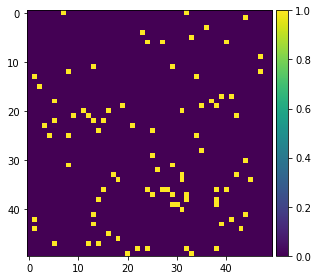

In [2]:
def data_generator(x=0, y=0, w=50, h=50):
    # pseudo-random point-pattern generation to have a reproducible dataset
    r = np.random.RandomState(x * y)
    coordinates = r.random((2, (x + 5) * (y + 5))) * np.asarray([[w],[h]])
    
    # create an image
    image = cle.create((h, w))
    # write at point coordinates
    cle.set(image, 0)
    cle.pointlist_to_labelled_spots(coordinates, image)
    
    # make binary image and retrieve from GPU
    result = cle.pull(image > 0)

    # for debugging; to see when the actual computation happens
    print("computing", x, y, np.sum(result))

    return result

example = data_generator(5, 4)

imshow(example)

In [3]:
def make_big_image(num_tiles_x=10, num_tiles_y=10, tile_width=50, tile_height=50):

    # we need to generate a single tile to know its shape and dtype
    example = data_generator()

    # setup the generator, which will be used many times to generate tiles
    delayed_generator = dask.delayed(data_generator)

    table = []
    for x in range(num_tiles_x):
        # set up a colum of tiles
        tiles = [delayed_generator(x, y, tile_width, tile_height) for y in range(num_tiles_y)]
        dask_tiles = [da.from_delayed(tile, shape=example.shape, dtype=example.dtype) for tile in tiles]
        column = da.concatenate(dask_tiles, axis=0)
        
        # collect column in a table
        table.append(column)

    # make a 2d tile dask array
    result = da.concatenate(table, axis=1)
    return result

big_image = make_big_image(num_tiles_x=50, num_tiles_y=50)
big_image

computing 0 0 25


dask.array<concatenate, shape=(2500, 2500), dtype=uint8, chunksize=(50, 50), chunktype=numpy.ndarray>

In [4]:
def process_image(image):
    print("blurring")
    return cle.pull(cle.gaussian_blur(image, sigma_x=1, sigma_y=2))

overlap_width = 5
processed_tiles = da.map_overlap(process_image, big_image, depth=overlap_width, boundary=0)
processed_tiles


blurring
blurring


dask.array<_trim, shape=(2500, 2500), dtype=float32, chunksize=(50, 50), chunktype=numpy.ndarray>

In [5]:
import napari
viewer = napari.Viewer()

viewer.add_image(example)

#viewer.add_image(big_image, cache=False, contrast_limits=[0, 1])

viewer.add_image(processed_tiles, cache=True, contrast_limits=[0, 1])

Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.


computingcomputing 0 0 25
 1 0 30
computing 1 1 36
computing 0 1 30
computing 2 0 35
computing 2 1 41
computing 4 0 44
computing 3 0 39
computing 3 1 47
blurring
blurring
blurringcomputing
 5 1 59
computingcomputing  6 0 52
5 0 50
computing 4 1 53
computing 6 1 63
computing 7 0 60
blurring
blurringcomputing 8 0 65

blurring
computing 7 1 71
computingcomputing 8 1 78
 computing 9 1 84
9 0 69
blurring
computing 10 1 87
blurringcomputing 10 0 75

blurring
blurring
computing 11 1 93
computing 11 0 80
computing 12 1 101
computingcomputing 12 0 83
computingcomputing 13 1 103
  1314  0 94
0 89
blurring
computing 14 1 111
computingblurring
 15 0 98
blurring
computingcomputing 16 0 102
 15 1 119
blurring
computing 16 1 121
computing 17 0 110
computing 17 1 127
blurring
blurring
blurring
computingcomputing 18 1 132
 18 0 111
computing 19 0 116
computing 19 1 139
computing 21 0 128
computing 20 0 123
computing 20 1 146
blurring
blurring
computing 21 1 155
computing 22 0 131
blurring
computing 23 

<Image layer 'processed_tiles' at 0x2b3829127c0>

In [6]:
viewer.add_image?

Signature:
viewer.add_image(
    data=None,
    *,
    channel_axis=None,
    rgb=None,
    colormap=None,
    contrast_limits=None,
    gamma=1,
    interpolation='nearest',
    rendering='mip',
    depiction='volume',
    iso_threshold=0.5,
    attenuation=0.05,
    name=None,
    metadata=None,
    scale=None,
    translate=None,
    rotate=None,
    shear=None,
    affine=None,
    opacity=1,
    blending=None,
    visible=True,
    multiscale=None,
    cache=True,
    plane=None,
    experimental_clipping_planes=None,
) -> 'Union[Image, List[Image]]'
Docstring:
Add an image layer to the layer list.

Parameters
----------
data : array or list of array
    Image data. Can be N >= 2 dimensional. If the last dimension has length
    3 or 4 can be interpreted as RGB or RGBA if rgb is `True`. If a
    list and arrays are decreasing in shape then the data is treated as
    a multiscale image. Please note multiscale rendering is only
    supported in 2D. In 3D, only the lowest resolution 

computingcomputingcomputing  1 0 30
 52 0 35
computing computing 11 0 80
computingcomputing 0computing  0 0 25
 3 10 0 39
50
 computing13 0 89
0 computingcomputing 75
 6 0computing7computing 15 0 98
 4 0 44
 12 0 83
 0 60
computing 8 0 65
 computing 14 0 94
52
computing 9 0 69
computing 16 0 102
computingcomputingcomputing  19 0 116
 computing2218  0 111
17 0 110
computing 27 0 158
computing 20 0 123
 computingcomputing0 131
computing 21 0 128
  23 0 135
26 0 150
computingcomputing 28 0 156
 25 0 149
computing 29 0 168
computing 30 0 170
computing 24 0 140
computing 31 0 173
computing 32 0 179
computing 35 0 197
computing 33 0 187
computing 36 0 200
computing 38 0 208
computingcomputingcomputing 34 0 188
 42 0 227
computingcomputing 39 0 214
 40 0 212
 37 0 199
computing 43 0 233
computing computing44 0 238
 computing 41 0 222
47 0 250
computing 46 0 247
computing 45 0 236
computing 48 0 250
computing 49 0 245
computing 0computing 1 30
 1 1 36
computing 6 1 63
computingcomputing 2 1 41

Low image data range; displaying image with stretched contrast.


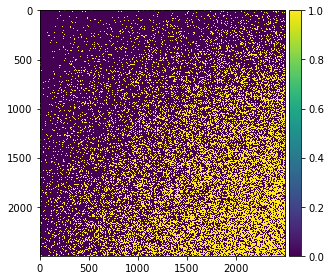

In [7]:
image = np.asarray(big_image)
print(np.sum(image))
imshow(image)